# Modelowanie procesu ryzyka

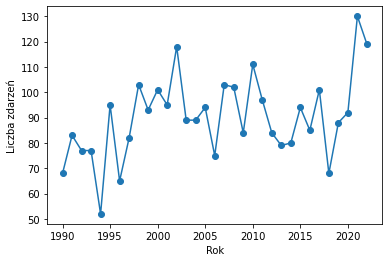

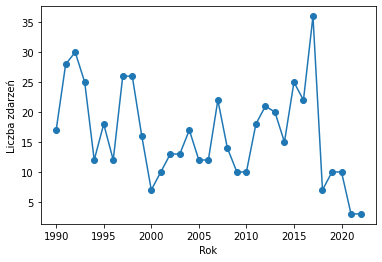

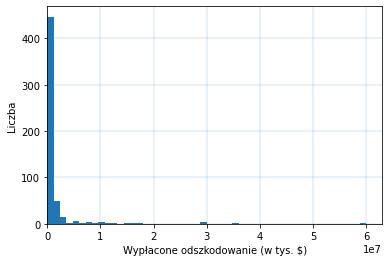

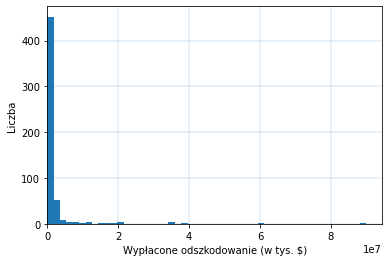

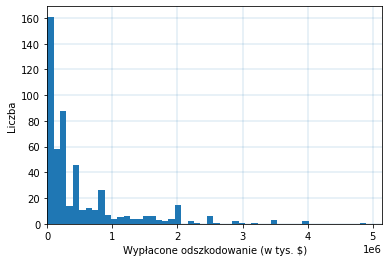

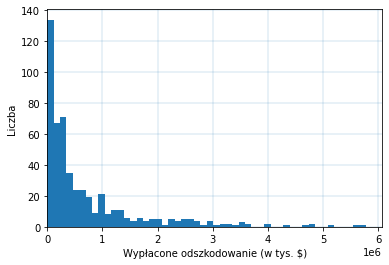

In [40]:
%run "C:\Users\ndzad\Dropbox\MINI\Magisterka\repo\mgr\DataPreparation.ipynb"

In [41]:
%run "C:\Users\ndzad\Dropbox\MINI\Magisterka\repo\mgr\Modelowanie_liczby_roszczen.ipynb"

      fun: 1375.1579339596738
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 4.54747313e-05, -2.27373677e-05, -2.51702660e-02,  4.54747313e-04])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 255
      nit: 42
     njev: 51
   status: 0
  success: True
        x: array([14.86573535,  6.34683826,  1.05347731,  8.96354863])
1     17
2     28
3     29
4     25
5     11
6     18
7     12
8     26
9     26
10    16
11     7
12    10
13    13
14    13
15    13
16     9
17    12
18    22
19    13
20    10
21     9
22    16
23    20
24    20
25    15
26    25
27    21
28    32
29     4
30    10
31     8
32     1
33     2
Name: Dis No, dtype: int64
Year
1      9
2     19
3     16
4      7
5     16
6     14
7      9
8     17
9     11
10    19
11    13
12    15
13    21
14    13
15    21
16    10
17    14
18    12
19    13
20    16
21     9
22    13
23    17
24    21
25    13
26    22
27     8
28    14
29    15
30    20
31    13
32    15
33    

In [42]:
%run "C:\Users\ndzad\Dropbox\MINI\Magisterka\repo\mgr\Modelowanie_wartosci_odszkodowan.ipynb"

1.395177366818116e-06
12.621668063027776 2.3407817241437945
1.0 1.0
-0.07922893559021643 275203.25662999536


C:\Users\ndzad\AppData\Local\Temp/ipykernel_20448/3568942317.py:5: RuntimeWarning: divide by zero encountered in log
  eq2 = np.log(np.mean(X)/np.power(np.prod(X),1/n))-np.log(alpha)+psi(alpha)
c:\Users\ndzad\anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [73]:
def risk_process(mu, theta, X_distribution, X_params, lambda_func, lambda_fun_params, t):
    """
    Funkcja generuje proces ryzyka dla zadanych parametrów.

    Argumenty:
        mu: float
            Kapitał początkowy
        theta: float
            Narzut
        X_distribution: string
            Rozkład z jakiego pochodzą wartości odzkodowań
        X_params:
            Parametry rozkładu z jakiego pochodzą wartości odszkodowań
        lambda_func: funkcja
            Funkcja intensywności
        lambda_func_params: tab
            Tablica zawierająca parametry funkcji intensywności
        t: int
            Maksymalna liczba lat
    Zwraca:
        numpy.ndarray
            Tablica procesu ryzyka.
    """ 
    n_pred = nhpp(lambda_func,lambda_fun_params,t+1)
    unique, counts = np.unique(np.ceil(n_pred[1]), return_counts=True)
    values = pd.DataFrame({'Year':unique, 'n':counts})
    index_df = pd.DataFrame({'Year':np.array(range(1,t+1))})
    merged_table = pd.merge(index_df, values, on='Year', how='left').fillna(0).set_index('Year')
    n_pred = pd.Series(merged_table['n']).astype(int)
    x = []
    y = []
    if X_distribution == 'expon':
        for i in range(1,t+1):
            x.append(sum(stats.expon.rvs(scale=1/X_params[0],size=n_pred[i])))
    S = np.cumsum(x)
    for i in range(0, t+1):
        y.append(sin_int_fun(i,lambda_fun_params)[0])
    Y = np.cumsum(y)[1:t+1]
    c = (1+theta)*mu*Y
    R = mu + c - S
    return np.insert(R,0,mu)

In [111]:
rp = risk_process(1e6,0.1,'expon',[1.395177366818116e-06],sin_int_fun,[14.86573535,  6.34683826,  1.05347731,  8.96354863],10)
rp

array([1.00000000e+06, 3.20031557e+07, 4.76074225e+07, 5.78329056e+07,
       7.20461413e+07, 8.59865730e+07, 9.80671479e+07, 1.10262005e+08,
       1.19707563e+08, 1.24431585e+08, 1.21241259e+08])

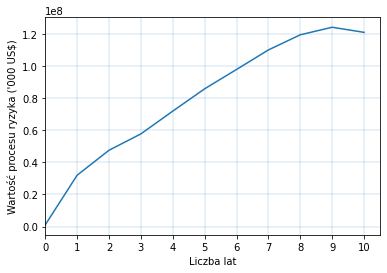

In [112]:
plt.plot(range(len(rp)), rp)
plt.xlabel("Liczba lat")
plt.ylabel("Wartość procesu ryzyka (\'000 US$)")
plt.grid(color='C0', linestyle='-', linewidth=0.2)
ax = plt.gca()
ax.set_xlim(left=0)
plt.xticks(range(len(rp)))
plt.show()

In [97]:
def empirical_risk_process(mu, theta, claims_series, lambda_func, lambda_fun_params, t):
    """
    Funkcja generuje proces ryzyka dla zadanych parametrów i danych.

    Argumenty:
        mu: float
            Kapitał początkowy
        theta: float
            Narzut
        claims_series: array
            Tablica zawierające dane o wartości wypłaconych odszkodowań w każdym roku
        lambda_func: funkcja
            Funkcja intensywności
        lambda_func_params: tab
            Tablica zawierająca parametry funkcji intensywności
        t: int
            Maksymalna liczba lat
    Zwraca:
        numpy.ndarray
            Tablica procesu ryzyka.
    """ 
    n_pred = nhpp(lambda_func,lambda_fun_params,t+1)
    unique, counts = np.unique(np.ceil(n_pred[1]), return_counts=True)
    values = pd.DataFrame({'Year':unique, 'n':counts})
    index_df = pd.DataFrame({'Year':np.array(range(1,t+1))})
    merged_table = pd.merge(index_df, values, on='Year', how='left').fillna(0).set_index('Year')
    n_pred = pd.Series(merged_table['n']).astype(int)
    S = np.cumsum(claims_series)
    y=[]
    for i in range(0, t+1):
        y.append(sin_int_fun(i,lambda_fun_params)[0])
    Y = np.cumsum(y)[1:t+1]
    c = (1+theta)*mu*Y
    R = mu + c - S
    return R

In [76]:
data_train = data_wo[data_wo["Year"]<2013]
data_test = data_wo[data_wo["Year"]>=2013]

In [92]:
claims_series = data_train.groupby("Year").sum()['Insured Damages (\'000 US$)']

In [109]:
erp = empirical_risk_process(1e6,0.1,claims_series,sin_int_fun,[14.86573535,  6.34683826,  1.05347731,  8.96354863],len(claims_series))

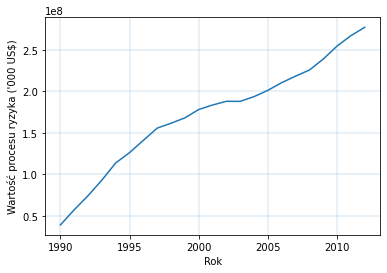

In [113]:
plt.plot(claims_series.index, erp)
plt.xlabel("Rok")
plt.ylabel("Wartość procesu ryzyka (\'000 US$)")
plt.grid(color='C0', linestyle='-', linewidth=0.2)
plt.show()